In [1]:
import pandas as pd
import os, sys, pandas, pathlib, time
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import random

Image.MAX_IMAGE_PIXELS = None #Throws error if size of images exceeds this number

In [2]:
#Creates dictionary mapping labels(string) to vector(one-hot encoding)
all_labels = list(np.load('materials/UBC-OCEAN_CS640/all_labels.npy'))
num_classes = len(all_labels)
label_dict = defaultdict(lambda: torch.zeros(num_classes))
for i, label in enumerate(all_labels):
    label_dict[label][i] = 1

In [3]:
    # change the size only if necessary
transform = v2.Compose([v2.Resize(256, antialias = True),
                            v2.CenterCrop(224),
                            v2.ToImage(),
                            v2.ToDtype(torch.float32, scale = True),
                            v2.Normalize(mean = [0.4887, 0.4266, 0.4855], std = [0.4212, 0.3790, 0.4169])])

In [4]:
## TODO: create list of transformed images and update dataset class removing transforms

def load_transform_images(folder_path):
    images = {}  # Dictionary to store transformed images

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):  # Check for .jpg files
            img_name = os.path.splitext(filename)[0]  # Extract the name (assuming it's a number)
            print(img_name)
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert image to RGB (if not already)
                transformed_img = transform(img)  # Apply the transformation
                images[img_name] = transformed_img  # Store in dictionary with name as key

    return images

# Example usage
folder_path = 'materials/UBC-OCEAN_CS640/train_images_compressed_80/'
transformed_images = load_transform_images(folder_path)

10077
10143
10252
10469
10548
10642
1080
10896
11263
11417
11431
11557
11559
12222
12244
12442
1252
12522
1289
12902
1295
13364
13387
13526
13987
14039
14051
14127
14312
14401
14424
14532
14542
14617
15139
15188
15209
15221
15231
15293
15470
15486
15583
15671
15742
16042
16064
16209
16325
16494
1666
16876
16986
17067
17174
17291
17365
17416
17487
17637
17738
1774
17854
18014
18138
18547
18607
18810
18813
18896
18981
19030
19157
1925
19255
1952
19569
20205
20312
20329
20670
20858
20882
2097
21020
21232
21303
21373
21432
21445
21910
21929
22155
22221
2227
22290
22425
22489
22654
22740
22924
23523
23796
2391
24023
24507
24563
24617
24759
24991
25561
25604
25792
25928
26025
26124
26190
26533
26603
26644
2666
26862
26950
2706
27245
27249
27315
27747
27851
27950
28028
28066
281
28121
28393
28519
28562
28603
28736
28821
28922
2906
29084
29147
29200
29240
29331
29615
29888
29904
30203
30369
30508
30515
3055
30712
30738
3084
30868
3092
31033
31297
31333
31383
31473
31594
31793
32032
32035
32042

In [5]:
## Create list of training images and validation images using a split
def split_dataset(images, train_ratio=0.8):
    total_images = len(images)
    train_size = int(total_images * train_ratio)

    # Randomly shuffle the images
    shuffled_items = list(images.items())
    random.shuffle(shuffled_items)

    # Split the images into training and validation sets
    train_images = dict(shuffled_items[:train_size])
    validation_images = dict(shuffled_items[train_size:])

    return train_images, validation_images

train_images, validation_images = split_dataset(transformed_images)


print(f'Number of training images: {len(train_images.keys())}')
print(f'Number of validation images: {len(validation_images.keys())}')
print(f'Type of key: {type(list(train_images.keys())[0])}')
print(f'Type of image: {type(list(train_images.values())[0])}')
print(f'Size of image: {list(train_images.values())[0].size()}')

Number of training images: 344
Number of validation images: 86
Type of key: <class 'str'>
Type of image: <class 'torchvision.tv_tensors._image.Image'>
Size of image: torch.Size([3, 224, 224])


In [6]:
##TODO: Update dataset to pass in list of images
class CustomDataset(Dataset):
    def __init__(self, csv_file, images, num_classes):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            num_classes (int): Total number of classes.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.images = images
        self.image_names = list(self.images.keys())  # List of image names
        self.num_classes = num_classes

    def __len__(self):
        return len(list(self.images.keys()))

    def __getitem__(self, idx):
        image = self.images[self.image_names[idx]]
        label = self.labels_frame.iloc[idx, 1]

        # Convert label to one-hot encoding
        one_hot = label_dict[label]
        return image, one_hot

In [7]:
## TODO: Add validation set and update method calls
batch_size = 32

# Create the dataset
train_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', images=train_images, num_classes=num_classes)
validation_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', images=validation_images, num_classes=num_classes)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# Now you can use this dataloader in your training loop

In [8]:
#Size of the reshaped first image in the data set
#(RGB * width * height)
print(f'Numer of training examples: {train_dataset.__len__()}')
print(f'Numer of testing examples: {validation_dataset.__len__()}')
print(f'Type of pairing: {type(train_dataset.__getitem__(0))}')
print(f'Number of inputs + outputs: {len(validation_dataset.__getitem__(0))}')
print(f'Size of input: {train_dataset.__getitem__(0)[0].size()}')
print(f'First input(normalized): {train_dataset.__getitem__(0)[0]}')
print(f'First output(one-hot encoding): {train_dataset.__getitem__(0)[1]}')

Numer of training examples: 344
Numer of testing examples: 86
Type of pairing: <class 'tuple'>
Number of inputs + outputs: 2
Size of input: torch.Size([3, 224, 224])
First input(normalized): Image([[[-1.1603, -1.1603, -1.1603,  ..., -1.1603, -1.1603, -1.1603],
        [-1.1603, -1.1603, -1.1603,  ..., -0.4434, -0.4061, -0.4061],
        [-1.1603, -1.1603, -1.1603,  ...,  0.8974,  0.9160,  0.9160],
        ...,
        [-1.1603, -1.1603, -1.1603,  ..., -1.1603, -1.1603, -1.1603],
        [-1.1603, -1.1603, -1.1603,  ..., -1.1603, -1.1603, -1.1603],
        [-1.1603, -1.1603, -1.1603,  ..., -1.1603, -1.1603, -1.1603]],

       [[-1.1256, -1.1256, -1.1256,  ..., -1.1256, -1.1256, -1.1256],
        [-1.1256, -1.1256, -1.1256,  ..., -0.3392, -0.2978, -0.2978],
        [-1.1256, -1.1256, -1.1256,  ...,  1.1197,  1.1404,  1.1404],
        ...,
        [-1.1256, -1.1256, -1.1256,  ..., -1.1256, -1.1256, -1.1256],
        [-1.1256, -1.1256, -1.1256,  ..., -1.1256, -1.1256, -1.1256],
        [-1

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [10]:
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Adjust the size of the fully connected layer
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 5) # Adjust according to the number of classes
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28) # Adjust this flattening based on the output size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# Step 4: Initialize the CNN Model
model_validation = CancerCNN().float()
print(model_validation)

model_validation = model_validation.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_validation.parameters(), lr=0.00001)

CancerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


  1%|          | 1/100 [00:01<01:42,  1.04s/it]

Epoch 1, Loss: 1.4474443197250366


  2%|▏         | 2/100 [00:01<01:11,  1.36it/s]

Epoch 2, Loss: 1.4715635776519775


  3%|▎         | 3/100 [00:02<01:01,  1.57it/s]

Epoch 3, Loss: 1.5187430381774902


  4%|▍         | 4/100 [00:02<00:58,  1.65it/s]

Epoch 4, Loss: 1.4127540588378906


  5%|▌         | 5/100 [00:03<00:55,  1.72it/s]

Epoch 5, Loss: 1.6803359985351562


  6%|▌         | 6/100 [00:03<00:53,  1.77it/s]

Epoch 6, Loss: 1.3370752334594727


  7%|▋         | 7/100 [00:04<00:51,  1.80it/s]

Epoch 7, Loss: 1.3713816404342651


  8%|▊         | 8/100 [00:04<00:50,  1.82it/s]

Epoch 8, Loss: 1.436234474182129


  9%|▉         | 9/100 [00:05<00:50,  1.80it/s]

Epoch 9, Loss: 1.1905831098556519


 10%|█         | 10/100 [00:05<00:50,  1.77it/s]

Epoch 10, Loss: 1.445035457611084


 11%|█         | 11/100 [00:06<00:50,  1.76it/s]

Epoch 11, Loss: 1.4140863418579102


 12%|█▏        | 12/100 [00:07<00:50,  1.74it/s]

Epoch 12, Loss: 1.4965299367904663


 13%|█▎        | 13/100 [00:07<00:50,  1.73it/s]

Epoch 13, Loss: 1.3228602409362793


 14%|█▍        | 14/100 [00:08<00:49,  1.72it/s]

Epoch 14, Loss: 1.331705093383789


 15%|█▌        | 15/100 [00:08<00:49,  1.72it/s]

Epoch 15, Loss: 1.2532979249954224


 16%|█▌        | 16/100 [00:09<00:49,  1.71it/s]

Epoch 16, Loss: 1.2269892692565918


 17%|█▋        | 17/100 [00:10<00:49,  1.68it/s]

Epoch 17, Loss: 1.2131675481796265


 18%|█▊        | 18/100 [00:10<00:49,  1.66it/s]

Epoch 18, Loss: 1.401677131652832


 19%|█▉        | 19/100 [00:11<00:48,  1.66it/s]

Epoch 19, Loss: 1.3666290044784546


 20%|██        | 20/100 [00:11<00:48,  1.65it/s]

Epoch 20, Loss: 1.4387974739074707


 21%|██        | 21/100 [00:12<00:47,  1.66it/s]

Epoch 21, Loss: 1.1328186988830566


 22%|██▏       | 22/100 [00:13<00:47,  1.66it/s]

Epoch 22, Loss: 1.0960451364517212


 23%|██▎       | 23/100 [00:13<00:46,  1.65it/s]

Epoch 23, Loss: 0.8414124846458435


 24%|██▍       | 24/100 [00:14<00:45,  1.65it/s]

Epoch 24, Loss: 1.0465339422225952


 25%|██▌       | 25/100 [00:14<00:45,  1.65it/s]

Epoch 25, Loss: 0.9881240129470825


 26%|██▌       | 26/100 [00:15<00:44,  1.65it/s]

Epoch 26, Loss: 1.040497064590454


 27%|██▋       | 27/100 [00:16<00:44,  1.65it/s]

Epoch 27, Loss: 1.045906662940979


 28%|██▊       | 28/100 [00:16<00:43,  1.65it/s]

Epoch 28, Loss: 0.9357819557189941


 29%|██▉       | 29/100 [00:17<00:43,  1.65it/s]

Epoch 29, Loss: 0.8369650840759277


 30%|███       | 30/100 [00:17<00:42,  1.65it/s]

Epoch 30, Loss: 0.8058956861495972


 31%|███       | 31/100 [00:18<00:41,  1.65it/s]

Epoch 31, Loss: 1.0124869346618652


 32%|███▏      | 32/100 [00:19<00:41,  1.64it/s]

Epoch 32, Loss: 1.0081456899642944


 33%|███▎      | 33/100 [00:19<00:40,  1.65it/s]

Epoch 33, Loss: 1.094836711883545


 34%|███▍      | 34/100 [00:20<00:40,  1.65it/s]

Epoch 34, Loss: 0.7921680212020874


 35%|███▌      | 35/100 [00:20<00:39,  1.65it/s]

Epoch 35, Loss: 0.7982851266860962


 36%|███▌      | 36/100 [00:21<00:39,  1.64it/s]

Epoch 36, Loss: 0.9672142863273621


 37%|███▋      | 37/100 [00:22<00:38,  1.64it/s]

Epoch 37, Loss: 0.9370402097702026


 38%|███▊      | 38/100 [00:22<00:37,  1.64it/s]

Epoch 38, Loss: 0.8761529922485352


 39%|███▉      | 39/100 [00:23<00:37,  1.64it/s]

Epoch 39, Loss: 0.7564972639083862


 40%|████      | 40/100 [00:24<00:36,  1.65it/s]

Epoch 40, Loss: 0.502284049987793


 41%|████      | 41/100 [00:24<00:35,  1.65it/s]

Epoch 41, Loss: 0.6533109545707703


 42%|████▏     | 42/100 [00:25<00:35,  1.65it/s]

Epoch 42, Loss: 0.606566309928894


 43%|████▎     | 43/100 [00:25<00:34,  1.65it/s]

Epoch 43, Loss: 0.5464760661125183


 44%|████▍     | 44/100 [00:26<00:34,  1.65it/s]

Epoch 44, Loss: 0.5472740530967712


 45%|████▌     | 45/100 [00:27<00:33,  1.65it/s]

Epoch 45, Loss: 0.7688881754875183


 46%|████▌     | 46/100 [00:27<00:32,  1.65it/s]

Epoch 46, Loss: 0.3889794945716858


 47%|████▋     | 47/100 [00:28<00:32,  1.65it/s]

Epoch 47, Loss: 0.7126474380493164


 48%|████▊     | 48/100 [00:28<00:31,  1.65it/s]

Epoch 48, Loss: 0.5906592011451721


 49%|████▉     | 49/100 [00:29<00:30,  1.65it/s]

Epoch 49, Loss: 0.658761203289032


 50%|█████     | 50/100 [00:30<00:30,  1.65it/s]

Epoch 50, Loss: 0.4265073239803314


 51%|█████     | 51/100 [00:30<00:29,  1.65it/s]

Epoch 51, Loss: 0.4246377646923065


 52%|█████▏    | 52/100 [00:31<00:29,  1.65it/s]

Epoch 52, Loss: 0.6315300464630127


 53%|█████▎    | 53/100 [00:31<00:28,  1.65it/s]

Epoch 53, Loss: 0.5591630339622498


 54%|█████▍    | 54/100 [00:32<00:27,  1.65it/s]

Epoch 54, Loss: 0.5164610147476196


 55%|█████▌    | 55/100 [00:33<00:27,  1.65it/s]

Epoch 55, Loss: 0.44101211428642273


 56%|█████▌    | 56/100 [00:33<00:26,  1.65it/s]

Epoch 56, Loss: 0.36619246006011963


 57%|█████▋    | 57/100 [00:34<00:26,  1.64it/s]

Epoch 57, Loss: 0.4622868001461029


 58%|█████▊    | 58/100 [00:34<00:25,  1.64it/s]

Epoch 58, Loss: 0.5355406403541565


 59%|█████▉    | 59/100 [00:35<00:24,  1.64it/s]

Epoch 59, Loss: 0.4041231572628021


 60%|██████    | 60/100 [00:36<00:24,  1.64it/s]

Epoch 60, Loss: 0.3608633279800415


 61%|██████    | 61/100 [00:36<00:23,  1.64it/s]

Epoch 61, Loss: 0.5246304273605347


 62%|██████▏   | 62/100 [00:37<00:23,  1.64it/s]

Epoch 62, Loss: 0.28834250569343567


 63%|██████▎   | 63/100 [00:38<00:22,  1.64it/s]

Epoch 63, Loss: 0.35069239139556885


 64%|██████▍   | 64/100 [00:38<00:21,  1.64it/s]

Epoch 64, Loss: 0.4158216416835785


 65%|██████▌   | 65/100 [00:39<00:21,  1.64it/s]

Epoch 65, Loss: 0.26637622714042664


 66%|██████▌   | 66/100 [00:39<00:20,  1.64it/s]

Epoch 66, Loss: 0.4115990996360779


 67%|██████▋   | 67/100 [00:40<00:20,  1.64it/s]

Epoch 67, Loss: 0.3091665208339691


 68%|██████▊   | 68/100 [00:41<00:19,  1.64it/s]

Epoch 68, Loss: 0.40485554933547974


 69%|██████▉   | 69/100 [00:41<00:18,  1.64it/s]

Epoch 69, Loss: 0.30653560161590576


 70%|███████   | 70/100 [00:42<00:18,  1.64it/s]

Epoch 70, Loss: 0.39275288581848145


 71%|███████   | 71/100 [00:42<00:17,  1.64it/s]

Epoch 71, Loss: 0.7726775407791138


 72%|███████▏  | 72/100 [00:43<00:17,  1.64it/s]

Epoch 72, Loss: 0.3947436511516571


 73%|███████▎  | 73/100 [00:44<00:16,  1.64it/s]

Epoch 73, Loss: 0.3202905058860779


 74%|███████▍  | 74/100 [00:44<00:15,  1.65it/s]

Epoch 74, Loss: 0.37396860122680664


 75%|███████▌  | 75/100 [00:45<00:15,  1.65it/s]

Epoch 75, Loss: 0.3939986824989319


 76%|███████▌  | 76/100 [00:45<00:14,  1.64it/s]

Epoch 76, Loss: 0.5046529173851013


 77%|███████▋  | 77/100 [00:46<00:13,  1.65it/s]

Epoch 77, Loss: 0.1738879680633545


 78%|███████▊  | 78/100 [00:47<00:13,  1.64it/s]

Epoch 78, Loss: 0.20263230800628662


 79%|███████▉  | 79/100 [00:47<00:12,  1.64it/s]

Epoch 79, Loss: 0.1501915156841278


 80%|████████  | 80/100 [00:48<00:12,  1.64it/s]

Epoch 80, Loss: 0.38774317502975464


 81%|████████  | 81/100 [00:48<00:11,  1.64it/s]

Epoch 81, Loss: 0.32227465510368347


 82%|████████▏ | 82/100 [00:49<00:10,  1.64it/s]

Epoch 82, Loss: 0.247283935546875


 83%|████████▎ | 83/100 [00:50<00:10,  1.64it/s]

Epoch 83, Loss: 0.22381584346294403


 84%|████████▍ | 84/100 [00:50<00:09,  1.64it/s]

Epoch 84, Loss: 0.31416505575180054


 85%|████████▌ | 85/100 [00:51<00:09,  1.64it/s]

Epoch 85, Loss: 0.3477294445037842


 86%|████████▌ | 86/100 [00:52<00:08,  1.64it/s]

Epoch 86, Loss: 0.27280303835868835


 87%|████████▋ | 87/100 [00:52<00:07,  1.64it/s]

Epoch 87, Loss: 0.2856002151966095


 88%|████████▊ | 88/100 [00:53<00:07,  1.64it/s]

Epoch 88, Loss: 0.1610693633556366


 89%|████████▉ | 89/100 [00:53<00:06,  1.64it/s]

Epoch 89, Loss: 0.5144535303115845


 90%|█████████ | 90/100 [00:54<00:06,  1.64it/s]

Epoch 90, Loss: 0.3310532569885254


 91%|█████████ | 91/100 [00:55<00:05,  1.64it/s]

Epoch 91, Loss: 0.44204849004745483


 92%|█████████▏| 92/100 [00:55<00:04,  1.64it/s]

Epoch 92, Loss: 0.1646588295698166


 93%|█████████▎| 93/100 [00:56<00:04,  1.64it/s]

Epoch 93, Loss: 0.39038366079330444


 94%|█████████▍| 94/100 [00:56<00:03,  1.64it/s]

Epoch 94, Loss: 0.3010135889053345


 95%|█████████▌| 95/100 [00:57<00:03,  1.64it/s]

Epoch 95, Loss: 0.2787036895751953


 96%|█████████▌| 96/100 [00:58<00:02,  1.64it/s]

Epoch 96, Loss: 0.1680304855108261


 97%|█████████▋| 97/100 [00:58<00:01,  1.64it/s]

Epoch 97, Loss: 0.3210277259349823


 98%|█████████▊| 98/100 [00:59<00:01,  1.64it/s]

Epoch 98, Loss: 0.2015029639005661


 99%|█████████▉| 99/100 [00:59<00:00,  1.64it/s]

Epoch 99, Loss: 0.32102927565574646


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Epoch 100, Loss: 0.12409891933202744


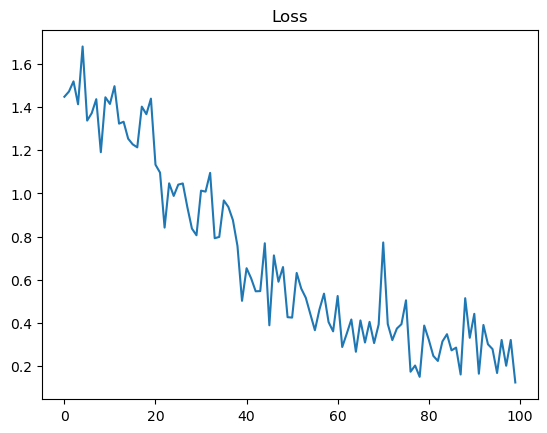

In [12]:
num_epochs = 100

losses = []


try:
    model_validation = torch.load('Cancer_CNN_validation.pt')
    img = mpimg.imread('loss_validation.png')
    imgplot = plt.imshow(img)
    plt.show()

except:

    model_validation.train()
    for epoch in tqdm(range(num_epochs)):  # Number of epochs
        for data, target in tqdm(train_dataloader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model_validation(data)
            #print(f'output: {output}')
            #print(f'target: {target.type_as(output)}\n')
            loss = criterion(output, target.type_as(output)) # Ensuring target is same type as output
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    torch.save(model_validation, 'Cancer_CNN_validation.pt')
        
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(losses)
    plt.title('Loss')
    plt.show()
    fig.savefig('loss_validation.png')

In [13]:
class CancerCNN_2(nn.Module):
    def __init__(self):
        super(CancerCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 5)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 512 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [14]:
# Step 4: Initialize the CNN Model
model_validation_2 = CancerCNN_2().float()
print(model_validation_2)

model_validation_2 = model_validation_2.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_validation_2.parameters(), lr=0.00001)

CancerCNN_2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


  1%|          | 1/100 [00:01<03:12,  1.94s/it]

Epoch 1, Loss: 0.14208005368709564


  2%|▏         | 2/100 [00:03<03:03,  1.87s/it]

Epoch 2, Loss: 0.1597188413143158


  3%|▎         | 3/100 [00:05<02:59,  1.85s/it]

Epoch 3, Loss: 0.10461802780628204


  4%|▍         | 4/100 [00:07<02:56,  1.84s/it]

Epoch 4, Loss: 0.19104591012001038


  5%|▌         | 5/100 [00:09<02:54,  1.84s/it]

Epoch 5, Loss: 0.19273459911346436


  6%|▌         | 6/100 [00:11<02:53,  1.85s/it]

Epoch 6, Loss: 0.26624614000320435


  7%|▋         | 7/100 [00:12<02:51,  1.84s/it]

Epoch 7, Loss: 0.22801463305950165


  8%|▊         | 8/100 [00:14<02:48,  1.83s/it]

Epoch 8, Loss: 0.12483459711074829


  9%|▉         | 9/100 [00:16<02:45,  1.82s/it]

Epoch 9, Loss: 0.2575828433036804


 10%|█         | 10/100 [00:18<02:43,  1.82s/it]

Epoch 10, Loss: 0.15218907594680786


 11%|█         | 11/100 [00:20<02:41,  1.82s/it]

Epoch 11, Loss: 0.2767186164855957


 12%|█▏        | 12/100 [00:21<02:39,  1.82s/it]

Epoch 12, Loss: 0.15993362665176392


 13%|█▎        | 13/100 [00:23<02:38,  1.82s/it]

Epoch 13, Loss: 0.07028764486312866


 14%|█▍        | 14/100 [00:25<02:38,  1.85s/it]

Epoch 14, Loss: 0.06601351499557495


 15%|█▌        | 15/100 [00:27<02:35,  1.83s/it]

Epoch 15, Loss: 0.15831224620342255


 16%|█▌        | 16/100 [00:29<02:33,  1.82s/it]

Epoch 16, Loss: 0.10657452791929245


 17%|█▋        | 17/100 [00:31<02:32,  1.83s/it]

Epoch 17, Loss: 0.1832333207130432


 18%|█▊        | 18/100 [00:33<02:29,  1.83s/it]

Epoch 18, Loss: 0.30898332595825195


 19%|█▉        | 19/100 [00:34<02:27,  1.82s/it]

Epoch 19, Loss: 0.15493188798427582


 20%|██        | 20/100 [00:36<02:25,  1.81s/it]

Epoch 20, Loss: 0.15461386740207672


 21%|██        | 21/100 [00:38<02:23,  1.82s/it]

Epoch 21, Loss: 0.07000540941953659


 22%|██▏       | 22/100 [00:40<02:21,  1.82s/it]

Epoch 22, Loss: 0.1458011269569397


 23%|██▎       | 23/100 [00:42<02:19,  1.81s/it]

Epoch 23, Loss: 0.18655914068222046


 24%|██▍       | 24/100 [00:43<02:17,  1.81s/it]

Epoch 24, Loss: 0.2509596347808838


 25%|██▌       | 25/100 [00:45<02:16,  1.81s/it]

Epoch 25, Loss: 8.355211321031675e-05


 26%|██▌       | 26/100 [00:47<02:14,  1.81s/it]

Epoch 26, Loss: 0.1961776614189148


 27%|██▋       | 27/100 [00:49<02:11,  1.80s/it]

Epoch 27, Loss: 0.11267857253551483


 28%|██▊       | 28/100 [00:51<02:09,  1.80s/it]

Epoch 28, Loss: 0.17587333917617798


 29%|██▉       | 29/100 [00:52<02:07,  1.79s/it]

Epoch 29, Loss: 0.040343888103961945


 30%|███       | 30/100 [00:54<02:05,  1.79s/it]

Epoch 30, Loss: 0.04168633744120598


 31%|███       | 31/100 [00:56<02:03,  1.79s/it]

Epoch 31, Loss: 0.17273418605327606


 32%|███▏      | 32/100 [00:58<02:00,  1.78s/it]

Epoch 32, Loss: 0.0702696293592453


 33%|███▎      | 33/100 [00:59<01:57,  1.76s/it]

Epoch 33, Loss: 0.07373318076133728


 34%|███▍      | 34/100 [01:01<01:55,  1.75s/it]

Epoch 34, Loss: 0.0013526708353310823


 35%|███▌      | 35/100 [01:03<01:53,  1.74s/it]

Epoch 35, Loss: 0.04036104306578636


 36%|███▌      | 36/100 [01:05<01:51,  1.74s/it]

Epoch 36, Loss: 0.1085812970995903


 37%|███▋      | 37/100 [01:06<01:49,  1.73s/it]

Epoch 37, Loss: 0.10829846560955048


 38%|███▊      | 38/100 [01:08<01:47,  1.73s/it]

Epoch 38, Loss: 0.10537275671958923


 39%|███▉      | 39/100 [01:10<01:45,  1.73s/it]

Epoch 39, Loss: 0.05692208930850029


 40%|████      | 40/100 [01:11<01:43,  1.73s/it]

Epoch 40, Loss: 0.11650218814611435


 41%|████      | 41/100 [01:13<01:42,  1.73s/it]

Epoch 41, Loss: 0.22472363710403442


 42%|████▏     | 42/100 [01:15<01:40,  1.73s/it]

Epoch 42, Loss: 0.0939391553401947


 43%|████▎     | 43/100 [01:17<01:38,  1.73s/it]

Epoch 43, Loss: 0.09666942059993744


 44%|████▍     | 44/100 [01:18<01:36,  1.73s/it]

Epoch 44, Loss: 0.15664416551589966


 45%|████▌     | 45/100 [01:20<01:34,  1.72s/it]

Epoch 45, Loss: 0.14149236679077148


 46%|████▌     | 46/100 [01:22<01:33,  1.73s/it]

Epoch 46, Loss: 0.21014468371868134


 47%|████▋     | 47/100 [01:24<01:31,  1.73s/it]

Epoch 47, Loss: 0.16182240843772888


 48%|████▊     | 48/100 [01:25<01:29,  1.73s/it]

Epoch 48, Loss: 0.2942984998226166


 49%|████▉     | 49/100 [01:27<01:28,  1.73s/it]

Epoch 49, Loss: 0.057692334055900574


 50%|█████     | 50/100 [01:29<01:26,  1.73s/it]

Epoch 50, Loss: 0.05733700841665268


 51%|█████     | 51/100 [01:30<01:24,  1.73s/it]

Epoch 51, Loss: 0.10639571398496628


 52%|█████▏    | 52/100 [01:32<01:22,  1.73s/it]

Epoch 52, Loss: 0.040887683629989624


 53%|█████▎    | 53/100 [01:34<01:21,  1.73s/it]

Epoch 53, Loss: 0.00014887579891365021


 54%|█████▍    | 54/100 [01:36<01:19,  1.72s/it]

Epoch 54, Loss: 0.17332898080348969


 55%|█████▌    | 55/100 [01:37<01:17,  1.72s/it]

Epoch 55, Loss: 0.09306307882070541


 56%|█████▌    | 56/100 [01:39<01:15,  1.72s/it]

Epoch 56, Loss: 0.16037358343601227


 57%|█████▋    | 57/100 [01:41<01:14,  1.72s/it]

Epoch 57, Loss: 0.15995053946971893


 58%|█████▊    | 58/100 [01:43<01:12,  1.72s/it]

Epoch 58, Loss: 0.06344275176525116


 59%|█████▉    | 59/100 [01:44<01:10,  1.72s/it]

Epoch 59, Loss: 0.19342714548110962


 60%|██████    | 60/100 [01:46<01:08,  1.72s/it]

Epoch 60, Loss: 0.16796773672103882


 61%|██████    | 61/100 [01:48<01:07,  1.72s/it]

Epoch 61, Loss: 0.29454147815704346


 62%|██████▏   | 62/100 [01:49<01:05,  1.72s/it]

Epoch 62, Loss: 0.06983726471662521


 63%|██████▎   | 63/100 [01:51<01:03,  1.73s/it]

Epoch 63, Loss: 0.0001582081022206694


 64%|██████▍   | 64/100 [01:53<01:02,  1.73s/it]

Epoch 64, Loss: 0.2617499828338623


 65%|██████▌   | 65/100 [01:55<01:00,  1.73s/it]

Epoch 65, Loss: 0.09382279217243195


 66%|██████▌   | 66/100 [01:56<00:58,  1.73s/it]

Epoch 66, Loss: 0.3278885781764984


 67%|██████▋   | 67/100 [01:58<00:57,  1.73s/it]

Epoch 67, Loss: 0.10663259029388428


 68%|██████▊   | 68/100 [02:00<00:55,  1.73s/it]

Epoch 68, Loss: 0.16815251111984253


 69%|██████▉   | 69/100 [02:02<00:53,  1.73s/it]

Epoch 69, Loss: 0.05900638550519943


 70%|███████   | 70/100 [02:03<00:51,  1.73s/it]

Epoch 70, Loss: 0.17597052454948425


 71%|███████   | 71/100 [02:05<00:50,  1.73s/it]

Epoch 71, Loss: 0.2564363181591034


 72%|███████▏  | 72/100 [02:07<00:48,  1.72s/it]

Epoch 72, Loss: 0.12889787554740906


 73%|███████▎  | 73/100 [02:08<00:46,  1.72s/it]

Epoch 73, Loss: 0.11476735770702362


 74%|███████▍  | 74/100 [02:10<00:44,  1.72s/it]

Epoch 74, Loss: 0.19386744499206543


 75%|███████▌  | 75/100 [02:12<00:43,  1.73s/it]

Epoch 75, Loss: 0.22553417086601257


 76%|███████▌  | 76/100 [02:14<00:41,  1.73s/it]

Epoch 76, Loss: 0.22357359528541565


 77%|███████▋  | 77/100 [02:15<00:39,  1.73s/it]

Epoch 77, Loss: 0.00022027731756679714


 78%|███████▊  | 78/100 [02:17<00:37,  1.73s/it]

Epoch 78, Loss: 0.226959228515625


 79%|███████▉  | 79/100 [02:19<00:36,  1.73s/it]

Epoch 79, Loss: 0.0960606187582016


 80%|████████  | 80/100 [02:21<00:34,  1.73s/it]

Epoch 80, Loss: 0.1240953803062439


 81%|████████  | 81/100 [02:22<00:32,  1.73s/it]

Epoch 81, Loss: 0.06914064288139343


 82%|████████▏ | 82/100 [02:24<00:31,  1.72s/it]

Epoch 82, Loss: 0.1490916758775711


 83%|████████▎ | 83/100 [02:26<00:29,  1.72s/it]

Epoch 83, Loss: 0.1837141513824463


 84%|████████▍ | 84/100 [02:27<00:27,  1.72s/it]

Epoch 84, Loss: 0.35311955213546753


 85%|████████▌ | 85/100 [02:29<00:25,  1.73s/it]

Epoch 85, Loss: 0.00012781003897543997


 86%|████████▌ | 86/100 [02:31<00:24,  1.78s/it]

Epoch 86, Loss: 0.1454845517873764


 87%|████████▋ | 87/100 [02:33<00:23,  1.78s/it]

Epoch 87, Loss: 0.12314676493406296


 88%|████████▊ | 88/100 [02:35<00:21,  1.78s/it]

Epoch 88, Loss: 0.16551582515239716


 89%|████████▉ | 89/100 [02:36<00:19,  1.78s/it]

Epoch 89, Loss: 0.11662685871124268


 90%|█████████ | 90/100 [02:38<00:17,  1.78s/it]

Epoch 90, Loss: 0.04147918522357941


 91%|█████████ | 91/100 [02:40<00:16,  1.78s/it]

Epoch 91, Loss: 0.17791184782981873


 92%|█████████▏| 92/100 [02:42<00:14,  1.77s/it]

Epoch 92, Loss: 0.07899226993322372


 93%|█████████▎| 93/100 [02:43<00:12,  1.76s/it]

Epoch 93, Loss: 0.08219287544488907


 94%|█████████▍| 94/100 [02:45<00:10,  1.75s/it]

Epoch 94, Loss: 0.1724298894405365


 95%|█████████▌| 95/100 [02:47<00:08,  1.78s/it]

Epoch 95, Loss: 9.599114855518565e-05


 96%|█████████▌| 96/100 [02:49<00:07,  1.78s/it]

Epoch 96, Loss: 0.11604861915111542


 97%|█████████▋| 97/100 [02:51<00:05,  1.82s/it]

Epoch 97, Loss: 0.04010476917028427


 98%|█████████▊| 98/100 [02:52<00:03,  1.81s/it]

Epoch 98, Loss: 0.244987353682518


 99%|█████████▉| 99/100 [02:54<00:01,  1.79s/it]

Epoch 99, Loss: 0.25361889600753784


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


Epoch 100, Loss: 0.20796190202236176


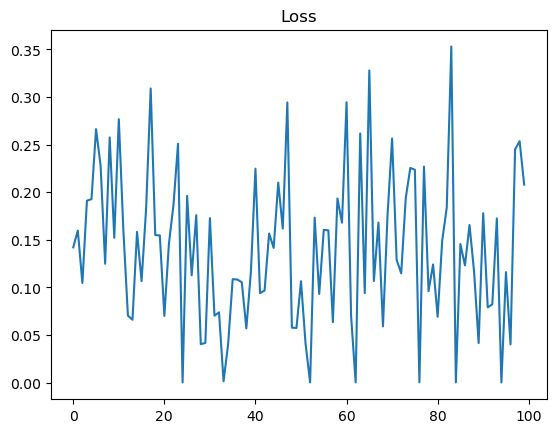

In [16]:
num_epochs = 1000

losses = []

try:
    model_validation_2 = torch.load('Cancer_CNN_validation_2.pt')
    img = mpimg.imread('loss_validation.png')
    imgplot = plt.imshow(img)
    plt.show()
    
except:
    model_validation_2.train()
    for epoch in tqdm(range(num_epochs)):  # Number of epochs
        for data, target in tqdm(train_dataloader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model_validation_2(data)
            #print(f'output: {output}')
            #print(f'target: {target.type_as(output)}\n')
            loss = criterion(output, target.type_as(output)) # Ensuring target is same type as output
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    torch.save(model_validation_2, 'Cancer_CNN_validation_2.pt')
        
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(losses)
    plt.title('Loss')
    plt.show()
    fig.savefig('loss_validation_2.png')